# Fanal

## A neutrino-less beta decay search 

## An open exercise


## Signal selection 


### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, 
with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext as pltext  # extensions for plotting histograms
import core.hfit   as hfit    # extension to fit histograms
import core.utils  as ut      # generic utilities

import ana.fanal  as fn

pltext.style()

## Indications

### Objectice

**Define** a selection or **an analysis strategy** to better identify bb0nu events and discard background events using simulated data.

### Tasks:

   * open the data file (HDF) and access the simulation data (MC) for the main backgrounds: 214Bi and 208Tl, and the bb0nu signal.

   * Inspect the variables. Identify the most powerful variables.
   
   * Replicate the 'fanal' analysis (see bellow).

   * Define a selection (a list of cuts) and compare it with the 'fanal' analysis.
   
      * You can also try a Multi-Variate methods, but it is not necessary.
      
   * Estimate the energy resolution using the Qbb peak.
   
 ### Notes:
 
 
   * The variable 'mcE' is the true energy, it is not measurable, and therefore can not be used in any analysis!
   
   * The rest of the varaibles are the 'measurable' quantities and can be used in the analysis.

## Access the data

In [5]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'

In [6]:
filename = '/data/alpha.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

Data path and filename :  /Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/alpha.h5


## inspect the variables



In [7]:
mcbb

,mcE,E,num_tracks,num_voxels,track0_E,track0_voxels,track0_length,blob1_E,blob2_E,track1_E,track1_voxels,track1_length,zave,rmax
39737,2.457830,2.457607,1.0,22,2.457607,22.0,111.161794,0.816814,0.663732,NaN,NaN,NaN,892.252930,484.900350
58468,2.457830,2.462779,1.0,22,2.462779,22.0,90.160544,0.637260,0.368158,NaN,NaN,NaN,900.861481,434.764715
41386,2.457830,2.455907,1.0,17,2.455907,17.0,40.363972,1.242743,0.952510,NaN,NaN,NaN,276.447861,159.837946
17044,2.457830,2.458673,2.0,22,2.428882,21.0,93.969620,1.004223,0.913697,0.029792,1.0,0.0,254.548317,417.690635
2904,2.457830,2.448094,1.0,28,2.448094,28.0,100.469167,0.900033,0.354771,NaN,NaN,NaN,823.537109,324.150728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16035,1.860900,1.857066,1.0,16,1.857066,16.0,26.352090,1.020577,0.452536,NaN,NaN,NaN,988.963318,427.951369
23674,2.457830,2.451785,1.0,26,2.451785,26.0,121.416525,1.001593,0.553555,NaN,NaN,NaN,1232.982117,381.472987
57746,2.092333,2.096309,1.0,13,2.096309,13.0,38.672433,1.177117,0.803900,NaN,NaN,NaN,743.975220,494.155363
13070,2.457830,2.463719,1.0,30,2.463719,30.0,169.048653,0.659759,0.288352,NaN,NaN,NaN,342.603943,282.831332


### Histogram the variables

We are drawing the variables only in the relevant range (2.6, 2.7 MeV)

In [8]:
mcs  = [mcbb, mcbi, mctl] # list of the mc DFs
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl'] # str names of the mc samples

In [9]:
# Draw all the variables of the data-frames for the mc samples
def selection(df, varname, varrange):
    """ apply the selection df.varname in a range, varange
    inputs:
        df       : dataFrame
        varname  : str, name of the variable int he DF
        varrange : tuple(float, float), range of the selection, all (-np.inf, np.inf)
    returns:
        sel      : np.array(bool) same same of DF with True/False
                   if the item fulfull variable value (varname) inside the range (varrange)
    """
    sel = (df[varname] >= varrange[0]) & (df[varname] < varrange[1])
    return sel



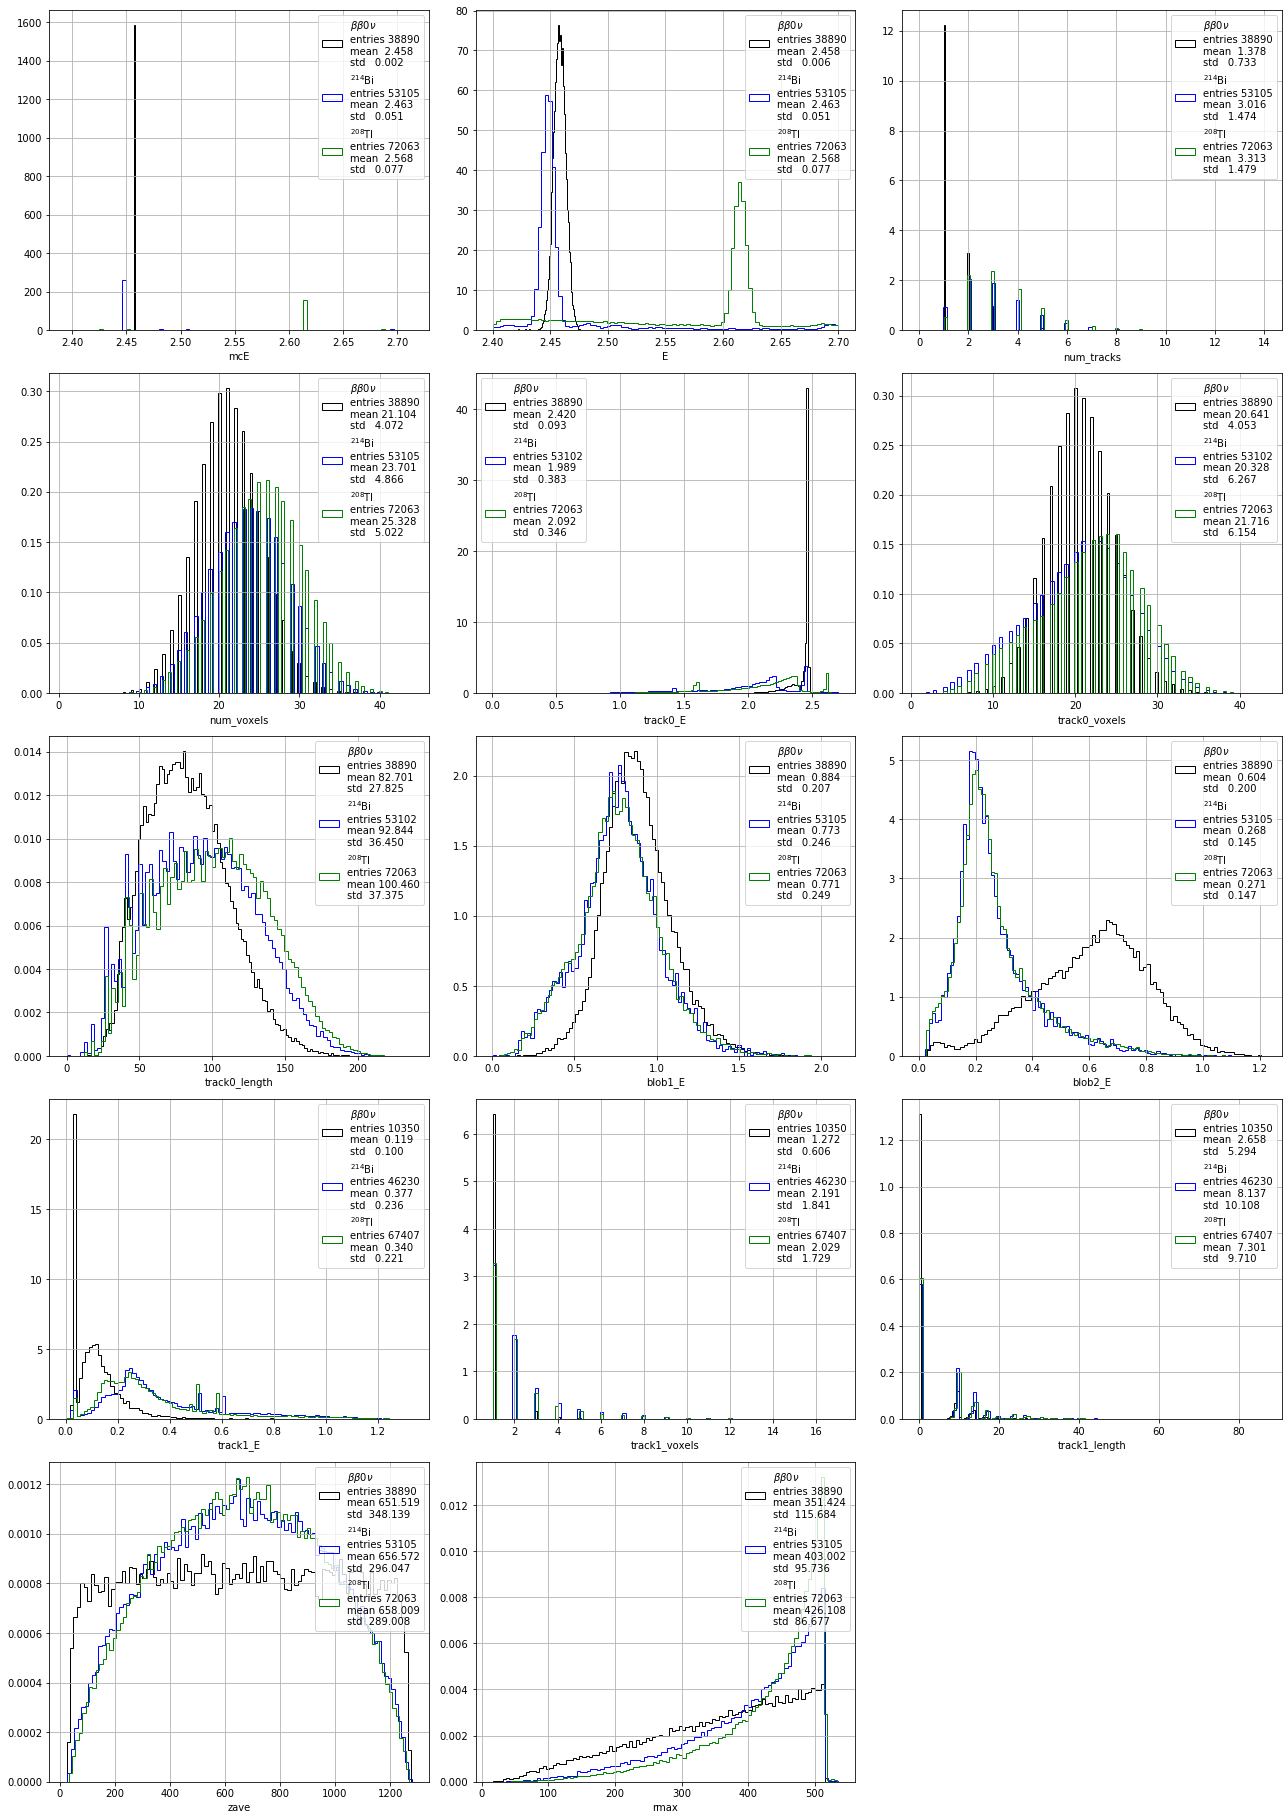

In [10]:
ename = 'E'
erange = (2.4, 2.7)       # energy range 
# filter the MC DF only consider events with energy in the energy-range
mcs  = [mc[selection(mc, ename, erange)] for mc in mcs]

# plot the distribution of all the variables
pltext.dfs_inspect(mcs, dfnames = ssamples, ncolumns = 3)

## Fanal analysis

The analysis is based in selecting a very pure sample of bb0nu. It applies a list of cuts. 

The experiment can be then consider either as a counting experiment (estimate the number of bkg events in the RoI and compare it with the number of observed events)

The 'fanal' selection has the following cuts:

   * Energy of the event is on the (2.4, 2.65) MeV range.
   
   * One reconstructed track. Most of the signal has only 1 track, while the background has in general more than one.
   
   * Second blob energy (the less energetic blob of the track) must have at least 400 keV. The signal has a real blob while the sedond blob of background must be in general the initial part of the electron track and should have smaller energy.
   
   * Region of Interest (RoI). The relevant gaussian region where the bb0nu is. In this example (2.44, 2.475) MeV
   

### Plot the analysis variables 

Plot the variables of the analysis for the different MC samples.

In [11]:
def plt_fanal_mc(mcs, ssamples, bins = 100, erange = (2.4, 2.65), eroi = (2.44, 2.475)):
    """ Plot the relevant analysis variables, for the different mc samples
    """

    subplot = pltext.canvas(5)

    subplot(1)
    for i, mc in enumerate(mcs):
        sel = (mc.E >= erange[0]) & (mc.E < erange[1])
        # sel = ut.in_range(mc.E, erange) equivalent using in_range method of utils
        pltext.hist(mc.E[sel], 100, label = ssamples[i], density = True)
        plt.xlabel('Energy (MeV)'); plt.title('E range');
    
    subplot(2)
    for i, mc in enumerate(mcs):
        sel  = ut.in_range(mc.E, erange)
        pltext.hist(mc.num_tracks[sel], 50, label = ssamples[i], density = True, range = (0, 15))
        plt.xlabel('number of tracks'); plt.title('E range')

    subplot(3)
    for i, mc in enumerate(mcs):
        sel  = ut.in_range(mc.E, erange) & mc.num_tracks == 1
        pltext.hist(mc.blob2_E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy blob2 (MeV)'); plt.title('E range - 1 track')

    subplot(4)
    for i, mc in enumerate(mcs):
        sel  = (ut.in_range(mc.E, erange)) & (mc.num_tracks == 1) & (mc.blob2_E >= 0.4)
        pltext.hist(mc.E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy (MeV)'); plt.title('E range - 1 track - blob2 cut')  
        
    subplot(5)
    for i, mc in enumerate(mcs):
        sel  = (ut.in_range(mc.E, eroi)) & (mc.num_tracks == 1) & (mc.blob2_E >= 0.4)
        pltext.hist(mc.E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy  (MeV)'); plt.title('E RoI - 1 track - blob2 cut') 
    
    plt.tight_layout();
    return

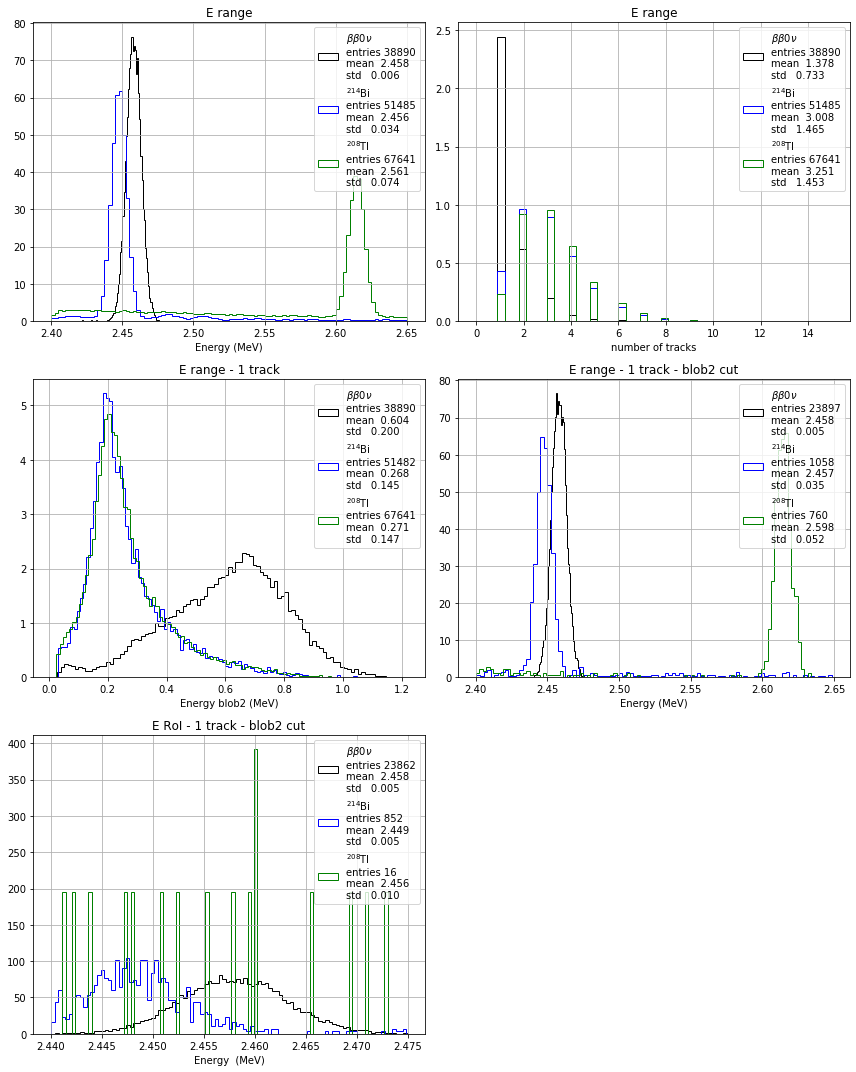

In [12]:
plt_fanal_mc(mcs, ssamples)

## Efficiencies

Compute and plot the efficiencies of the cuts: 

  * Energy in (2.4, 2.7) MeV
  
  * One track
  
  * Second blob Energy > 400 keV
  
  * Fine RoI (2.440, 2.475)

In [13]:
erange     = (2.400, 2.650)
eroi       = (2.440, 2.475)
selnames  = ['E', 'num_tracks', 'blob2_E', 'E']
selranges = [erange, (1., 1.1), (0.4, np.inf), eroi]

In [14]:
def selections(df, varnames, varranges):
    """ appy a list of selections in order in a data-frame
    inputs:
        df        : DataFrame
        varnames  : tuple(str), list of the variables of the selections
        varranges : tuple(float, float), range of the variables in the selection
    returns:
        sels: tuple(np.array(bool)), tuple with the selections applied in series
    """
    sel, sels =  None, []
    for i, varname in enumerate(varnames):
        isel = selection(df, varname, varranges[i])
        sel  = isel if sel is None else sel & isel
        sels.append(sel)
    return sels

def efficiency(sel, n = None):
    """ compute the efficiency and uncertanty of a selection
    inputs:
        sel: np.array(bool), bool array with True/False
        n  : int, denominator, if n is None, use len(sel)
    returns:
        eff : float, efficiency
        ueff: float, efficiency uncertainty
    """
    n    = n if n is not None else len(sel)
    eff  = np.sum(sel)/n
    ueff = np.sqrt(eff * (1- eff) / n)
    return eff, ueff

$\beta\beta0\nu$ :  E 1.00000 num_tracks 0.73386 blob2_E 0.61448 RoI 0.61358
$^{214}$Bi :  E 0.96949 num_tracks 0.12509 blob2_E 0.01992 RoI 0.01604
$^{208}$Tl :  E 0.93864 num_tracks 0.06457 blob2_E 0.01055 RoI 0.00022


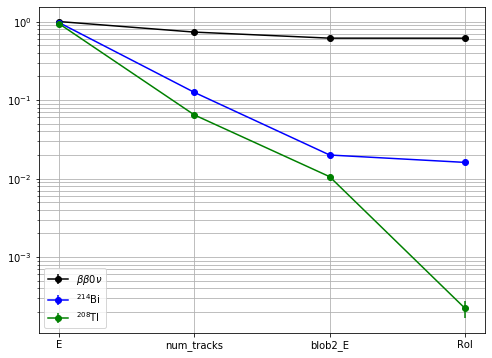

In [15]:
erange    = (2.400, 2.650)
eroi      = (2.440, 2.475)
varnames  = ['E', 'num_tracks', 'blob2_E', 'E']
varranges = [erange, (1., 1.1), (0.4, np.inf), eroi]
selnames  = ['E', 'num_tracks', 'blob2_E', 'RoI']

subplot = pltext.canvas(1, 1, 6, 8)
subplot(1)
for i, mc in enumerate(mcs):
    sels = selections(mc, varnames, varranges)
    effs = [efficiency(sel) for sel in sels]
    veff = [eff[0] for eff in effs] # efficiencies values
    ueff = [eff[1] for eff in effs] # efficiencies uncertainties
    print(ssamples[i], ': ', *['{:s} {:6.5f}'.format(s, eff) for s, eff in zip(selnames, veff)])
    plt.errorbar(selnames, veff, yerr = ueff, marker = 'o', label = ssamples[i])
plt.grid(which = 'both'); plt.yscale('log'); plt.legend();

## Estimate the energy resolution 

The energy resolution is a crucial parameters in this analysis.

Fit the energy distribution of the photo-peaks of Bi214, Tl208 and the bb0nu Qbb.

You can fit to a gaussian distribution or to a gaussian on top of a pedestal modeled with a straight line.

You can give the relative energy resolution as the sigma/E or FWHM/E.

Energy resolution:   0.50 % FWHM at Qbb


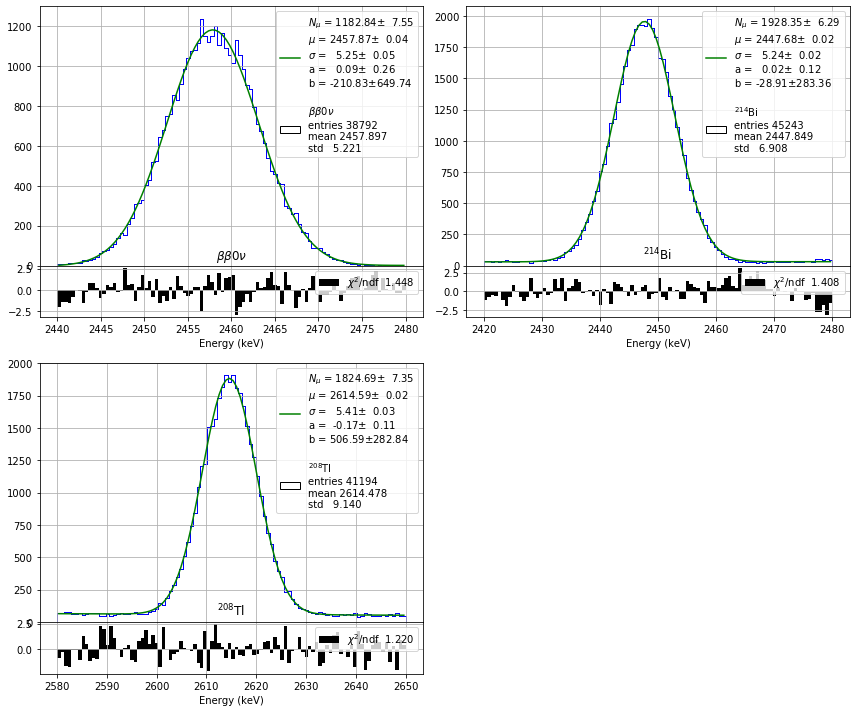

In [16]:
eranges = ((2440, 2480), (2420., 2480.), (2580, 2650))
fitfuns = ('gausline', 'gausline', 'gausline')
guesses =((50e3, 2458., 20., 0., 0.), (10e3, 2445., 20., 0., 300.), (50e3, 2615., 20., 0., 1.))

subplot = pltext.canvas(4)

for i, mc in enumerate(mcs):
    subplot(i + 1)
    pltext.hist(1e3 * mc.E, 100, range = eranges[i], label = ssamples[i]);
    pltext.hfitres(1e3 * mc.E, 100, range = eranges[i], fun = fitfuns[i], guess = guesses[i])
    plt.xlabel('Energy (keV)'); plt.title(ssamples[i])
plt.tight_layout();

print('Energy resolution: {:6.2f} % FWHM at Qbb'.format(100. * 5.25 * 2.35 / 2457.8))